In [121]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [122]:
df_aqe = pd.read_csv('AQE.csv')
df_aqw = pd.read_csv('AQW.csv')

In [123]:
# Convert date columns to datetime format
df_aqe['Date'] = pd.to_datetime(df_aqe['Date'], format='%m/%d/%Y')
df_aqw['Time'] = pd.to_datetime(df_aqw['Time'], format='%Y/%m/%d')

In [124]:
# Merge the dataframes on the standardized date column
df_merged = pd.merge(df_aqe, df_aqw, left_on='Date', right_on='Time', how='inner')

In [125]:
df_merged

,Date,Source,Site ID,POC,Daily Max 1-hour NO2 Concentration,Units,Daily AQI Value,Local Site Name,Daily Obs Count,Percent Complete,...,Humidity (%) MAX,Humidity (%) AVG,Humidity (%) MIN,Wind Speed (mph) MAX,Wind Speed (mph) AVG,Wind Speed (mph) MIN,Pressure (in) MAX,Pressure (in) AVG,Pressure (in) MIN,Precipitation
0,2021-01-01,AQS,60371103,1,35.6,ppb,33,Los Angeles-North Main Street,24,100,...,50,26.5,15,14,7.0,0,29.4,29.3,29.2,0.00
1,2021-01-02,AQS,60371103,1,30.8,ppb,28,Los Angeles-North Main Street,24,100,...,80,55.1,28,8,2.2,0,29.4,29.4,29.4,0.00
2,2021-01-03,AQS,60371103,1,25.9,ppb,24,Los Angeles-North Main Street,24,100,...,97,83.3,50,7,2.3,0,29.4,29.4,29.3,0.00
3,2021-01-04,AQS,60371103,1,35.8,ppb,33,Los Angeles-North Main Street,24,100,...,86,74.0,48,8,2.0,0,29.4,29.3,29.3,0.00
4,2021-01-05,AQS,60371103,1,34.9,ppb,32,Los Angeles-North Main Street,24,100,...,90,73.2,42,9,2.8,0,29.3,29.3,29.2,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1401,2024-11-26,AQS,60371103,1,46.4,ppb,43,Los Angeles-North Main Street,24,100,...,100,62.5,0,10,3.9,0,29.3,29.3,29.2,0.00
1402,2024-11-27,AQS,60371103,1,24.3,ppb,23,Los Angeles-North Main Street,24,100,...,93,51.0,0,12,3.1,0,29.2,29.2,29.1,0.04
1403,2024-11-28,AQS,60371103,1,33.9,ppb,31,Los Angeles-North Main Street,24,100,...,93,45.1,17,8,1.7,0,29.3,29.2,29.1,0.00
1404,2024-11-29,AQS,60371103,1,30.2,ppb,28,Los Angeles-North Main Street,24,100,...,41,27.0,15,9,3.3,0,29.3,29.2,29.2,0.00


In [126]:
df_merged.drop(['Source', 'Site ID', 'Daily Obs Count', 'Percent Complete', 'AQS Parameter Code', 'AQS Parameter Description', 'Method Code', 'CBSA Code', 'CBSA Name', 'State FIPS Code', 'State', 'County FIPS Code', 'County', 'Site Latitude', 'Site Longitude'], axis=1, inplace=True)

In [127]:
df_merged.shape

(1406, 23)

In [128]:
df_merged.drop(['Units', 'Local Site Name'], axis=1, inplace=True)

In [129]:
df_merged.drop(['POC'], axis=1, inplace=True)

In [130]:
df_merged.drop(['Daily AQI Value'], axis=1, inplace=True)

In [131]:
df_merged

,Date,Daily Max 1-hour NO2 Concentration,Time,Temperature (°F) MAX,Temperature (°F) AVG,Temperature (°F) MIN,Dew Point (°F) MAX,Dew Point (°F) AVG,Dew Point (°F) MIN,Humidity (%) MAX,Humidity (%) AVG,Humidity (%) MIN,Wind Speed (mph) MAX,Wind Speed (mph) AVG,Wind Speed (mph) MIN,Pressure (in) MAX,Pressure (in) AVG,Pressure (in) MIN,Precipitation
0,2021-01-01,35.6,2021-01-01,69,59.0,48,30,22.9,18,50,26.5,15,14,7.0,0,29.4,29.3,29.2,0.00
1,2021-01-02,30.8,2021-01-02,64,53.0,43,47,36.3,28,80,55.1,28,8,2.2,0,29.4,29.4,29.4,0.00
2,2021-01-03,25.9,2021-01-03,61,50.1,45,48,44.7,41,97,83.3,50,7,2.3,0,29.4,29.4,29.3,0.00
3,2021-01-04,35.8,2021-01-04,64,52.4,43,49,43.8,38,86,74.0,48,8,2.0,0,29.4,29.3,29.3,0.00
4,2021-01-05,34.9,2021-01-05,67,52.5,42,48,43.4,39,90,73.2,42,9,2.8,0,29.3,29.3,29.2,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1401,2024-11-26,46.4,2024-11-26,65,46.9,0,59,41.6,0,100,62.5,0,10,3.9,0,29.3,29.3,29.2,0.00
1402,2024-11-27,24.3,2024-11-27,68,38.8,0,57,34.7,0,93,51.0,0,12,3.1,0,29.2,29.2,29.1,0.04
1403,2024-11-28,33.9,2024-11-28,73,60.9,50,53,34.1,17,93,45.1,17,8,1.7,0,29.3,29.2,29.1,0.00
1404,2024-11-29,30.2,2024-11-29,68,57.6,49,27,22.6,18,41,27.0,15,9,3.3,0,29.3,29.2,29.2,0.00


In [132]:
data1 = df_merged.set_index('Date')
data1.index = pd.to_datetime(data1.index)

C:\Users\agila\AppData\Local\Temp\ipykernel_11404\2913879153.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Time'] = pd.to_datetime(df_filtered['Time'])
C:\Users\agila\AppData\Local\Temp\ipykernel_11404\2913879153.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Time'] = df_filtered['Time'].dt.strftime('%m/%d/%Y')


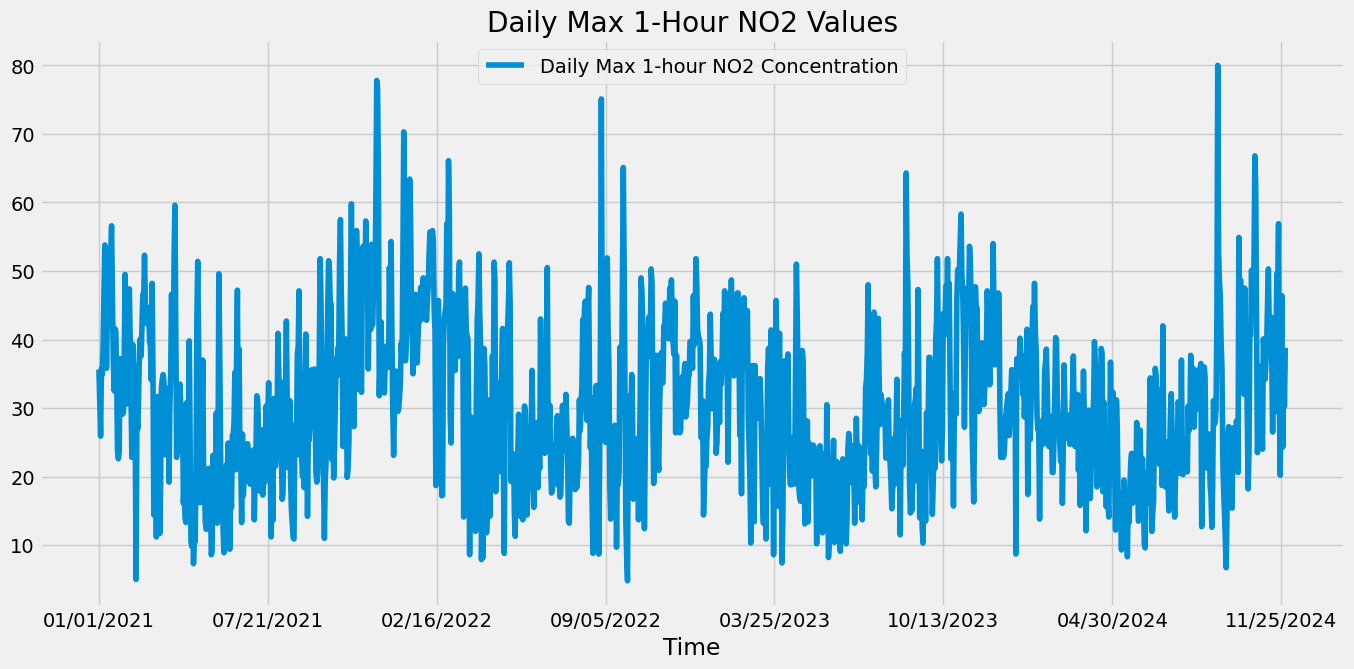

In [133]:
df_filtered = data1[['Time', 'Daily Max 1-hour NO2 Concentration']]

# Convert Date to datetime format and format it to MM/DD/YYYY
df_filtered['Time'] = pd.to_datetime(df_filtered['Time'])
df_filtered['Time'] = df_filtered['Time'].dt.strftime('%m/%d/%Y')

# Plot the filtered data
df_filtered.set_index('Time', inplace=True)
df_filtered.plot(
    figsize=(15, 7),
    color=color_pal[0],
    title='Daily Max 1-Hour NO2 Values'
)

# Show the plot
plt.show()

<Axes: ylabel='Frequency'>

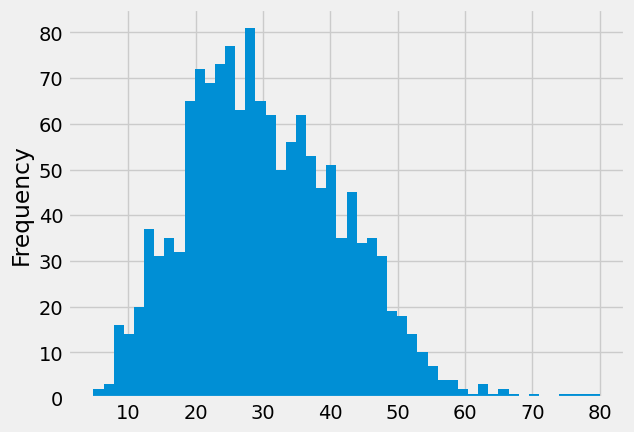

In [134]:
data1['Daily Max 1-hour NO2 Concentration'].plot(kind='hist', bins=50)

In [135]:
from sklearn.model_selection import TimeSeriesSplit

In [136]:
tss = TimeSeriesSplit(n_splits=3, test_size=365*1, gap=31)

In [137]:
data = data1.sort_index()

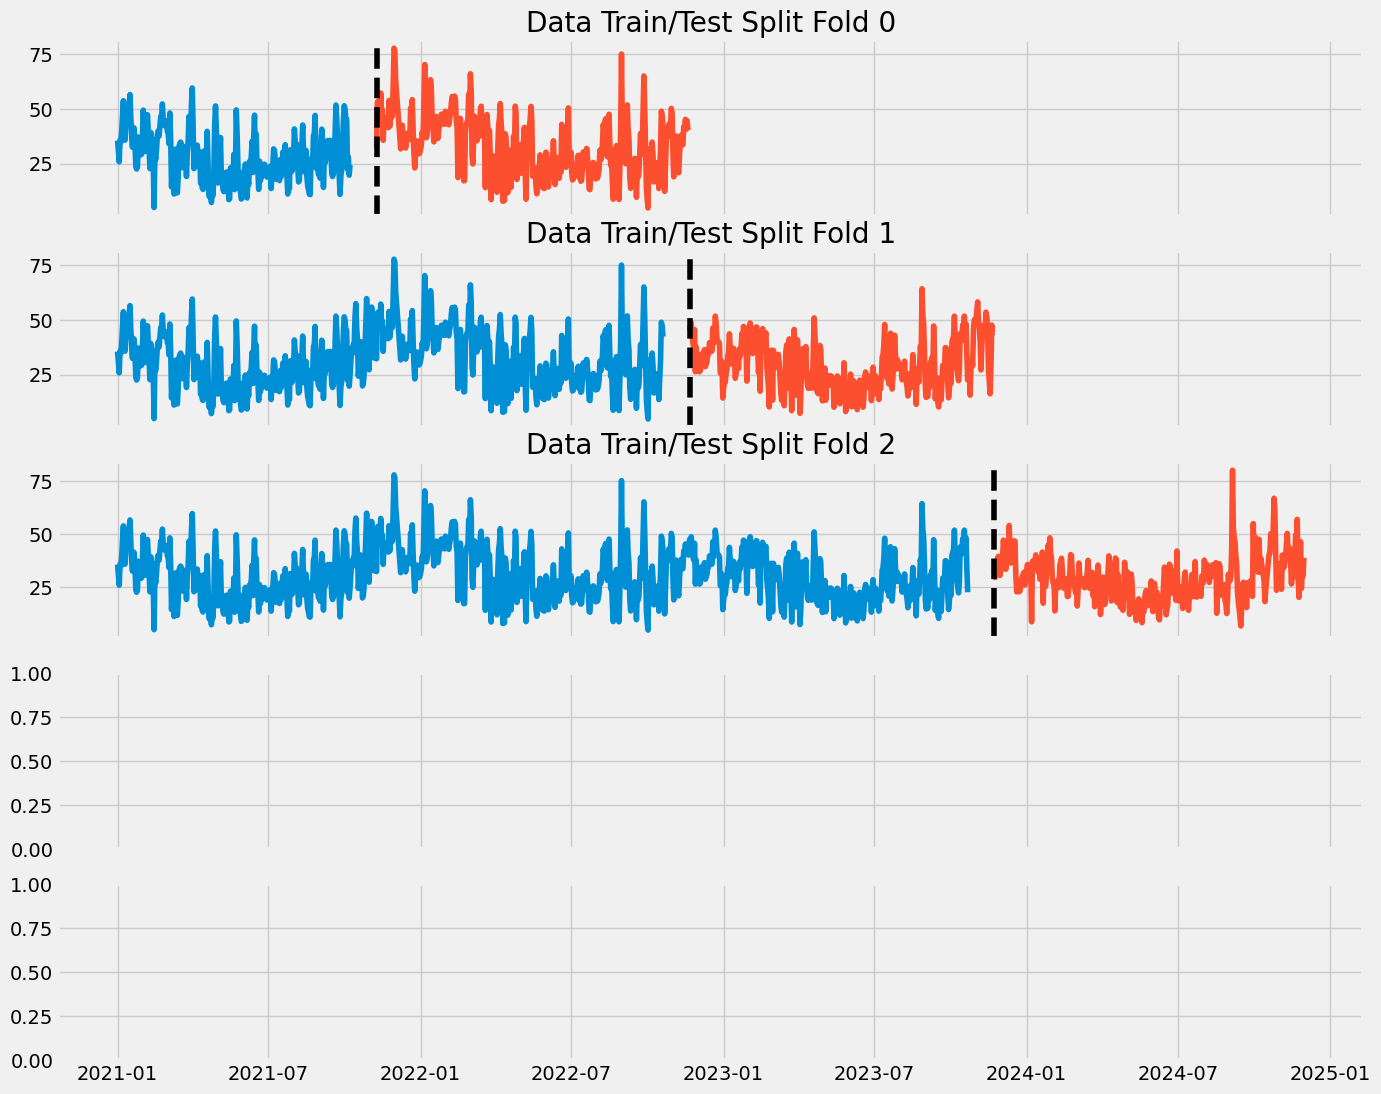

In [138]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0

for train_idx, val_idx in tss.split(data):
    train = data.iloc[train_idx]
    test = data.iloc[val_idx]
    train['Daily Max 1-hour NO2 Concentration'].plot(ax=axs[fold],
                                                      label='Training Set',
                                                      title=f'Data Train/Test Split Fold {fold}')
    test['Daily Max 1-hour NO2 Concentration'].plot(ax=axs[fold],
                                                     label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1

In [139]:
def create_features(data):
  data = data.copy()
  data['dayofweek'] = data.index.dayofweek
  data['quarter'] = data.index.quarter
  data['month'] = data.index.month
  data['year'] = data.index.year
  data['dayofyear'] = data.index.dayofyear
  data['dayofmonth'] = data.index.day
  data['weekofyear'] = data.index.isocalendar().week
  return data

data = create_features(data)

In [140]:
def add_lags(data):
  target_map = data['Daily Max 1-hour NO2 Concentration'].to_dict()
  data['lag1'] = (data.index - pd.Timedelta('7 days')).map(target_map)
  data['lag2'] = (data.index - pd.Timedelta('14 days')).map(target_map)
  data['lag3'] = (data.index - pd.Timedelta('31 days')).map(target_map)
  data['lag4'] = (data.index - pd.Timedelta('92 days')).map(target_map)
  data['lag5'] = (data.index - pd.Timedelta('364 days')).map(target_map)
  data['lag6'] = (data.index - pd.Timedelta('728 days')).map(target_map)
  return data

In [141]:
data = add_lags(data)

In [142]:
data

,Daily Max 1-hour NO2 Concentration,Time,Temperature (°F) MAX,Temperature (°F) AVG,Temperature (°F) MIN,Dew Point (°F) MAX,Dew Point (°F) AVG,Dew Point (°F) MIN,Humidity (%) MAX,Humidity (%) AVG,...,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3,lag4,lag5,lag6
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-01,35.6,2021-01-01,69,59.0,48,30,22.9,18,50,26.5,...,2021,1,1,53,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-02,30.8,2021-01-02,64,53.0,43,47,36.3,28,80,55.1,...,2021,2,2,53,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-03,25.9,2021-01-03,61,50.1,45,48,44.7,41,97,83.3,...,2021,3,3,53,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-04,35.8,2021-01-04,64,52.4,43,49,43.8,38,86,74.0,...,2021,4,4,1,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-05,34.9,2021-01-05,67,52.5,42,48,43.4,39,90,73.2,...,2021,5,5,1,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-26,46.4,2024-11-26,65,46.9,0,59,41.6,0,100,62.5,...,2024,331,26,48,39.1,41.5,62.0,26.2,39.5,37.7
2024-11-27,24.3,2024-11-27,68,38.8,0,57,34.7,0,93,51.0,...,2024,332,27,48,49.6,43.3,41.1,18.6,34.3,29.3
2024-11-28,33.9,2024-11-28,73,60.9,50,53,34.1,17,93,45.1,...,2024,333,28,48,47.4,36.8,23.5,17.2,30.5,28.9


In [143]:
data.isnull().sum()

Daily Max 1-hour NO2 Concentration      0
Time                                    0
Temperature (°F) MAX                    0
Temperature (°F) AVG                    0
Temperature (°F) MIN                    0
Dew Point (°F) MAX                      0
Dew Point (°F) AVG                      0
Dew Point (°F) MIN                      0
Humidity (%) MAX                        0
Humidity (%) AVG                        0
Humidity (%) MIN                        0
Wind Speed (mph) MAX                    0
Wind Speed (mph) AVG                    0
Wind Speed (mph) MIN                    0
Pressure (in) MAX                       0
Pressure (in) AVG                       0
Pressure (in) MIN                       0
Precipitation                           0
dayofweek                               0
quarter                                 0
month                                   0
year                                    0
dayofyear                               0
dayofmonth                        

In [144]:
tss =  TimeSeriesSplit(n_splits=3, test_size=365*1, gap=31)
data = data.sort_index()

fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(data):
  train = data.iloc[train_idx]
  test = data.iloc[val_idx]

  TARGET = 'Daily Max 1-hour NO2 Concentration'
  FEATURES = ['dayofyear', 'dayofweek', 'quarter', 'month', 'year', 'lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'Temperature (°F) MAX', 'Temperature (°F) AVG', 'Temperature (°F) MIN', 'Dew Point (°F) MAX', 'Dew Point (°F) AVG', 'Dew Point (°F) MIN', 'Humidity (%) MAX', 'Humidity (%) AVG', 'Humidity (%) MIN', 'Wind Speed (mph) MAX', 'Wind Speed (mph) AVG', 'Wind Speed (mph) MIN', 'Pressure (in) AVG', 'Pressure (in) MIN', 'Precipitation']

  X_train = train[FEATURES]
  y_train = train[TARGET]

  X_test = test[FEATURES]
  y_test = test[TARGET]

  reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                         n_estimators=1000,
                         early_stopping_rounds=50,
                         objective='reg:linear',
                         max_depth=3,
                         learning_rate=0.01)
  reg.fit(X_train, y_train,
          eval_set=[(X_train, y_train), (X_test, y_test)],
          verbose=100)

  y_pred = reg.predict(X_test)
  preds.append(y_pred)
  score = np.sqrt(mean_squared_error(y_test, y_pred))
  scores.append(score)

AttributeError: module 'pandas' has no attribute 'Int64Index'

In [ ]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores: {scores}')

Score across folds 7.0330
Fold scores: [np.float64(8.451471705752772), np.float64(6.482484241625418), np.float64(6.164990409492974)]


In [ ]:
# Retrain on all data
data = create_features(data)

FEATURES = ['dayofyear', 'dayofweek', 'quarter', 'month', 'year', 'lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'Temperature (°F) MAX', 'Temperature (°F) AVG', 'Temperature (°F) MIN', 'Dew Point (°F) MAX', 'Dew Point (°F) AVG', 'Dew Point (°F) MIN', 'Humidity (%) MAX', 'Humidity (%) AVG', 'Humidity (%) MIN', 'Wind Speed (mph) MAX', 'Wind Speed (mph) AVG', 'Wind Speed (mph) MIN', 'Pressure (in) AVG', 'Pressure (in) MIN', 'Precipitation']
TARGET = 'Daily Max 1-hour NO2 Concentration'

X_all = data[FEATURES]
y_all = data[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',
                       n_estimators=500,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[0]	validation_0-rmse:31.81783
[100]	validation_0-rmse:13.36265


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:04:16] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:7.61938
[300]	validation_0-rmse:6.09234
[400]	validation_0-rmse:5.59535
[499]	validation_0-rmse:5.32439


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

In [ ]:
data.index.max()

Timestamp('2024-11-30 00:00:00')

In [ ]:
# Create future dataframe
future = pd.date_range('2024-11-30', '2025-11-01')
future_data = pd.DataFrame(index=future)
future_data['isFuture'] = True
data['isFuture'] = False
data_and_future = pd.concat([data, future_data])
data_and_future = create_features(data_and_future)
data_and_future = add_lags(data_and_future)

In [ ]:
future_w_features = data_and_future.query('isFuture').copy()

In [ ]:
# Predict the Future

In [ ]:
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

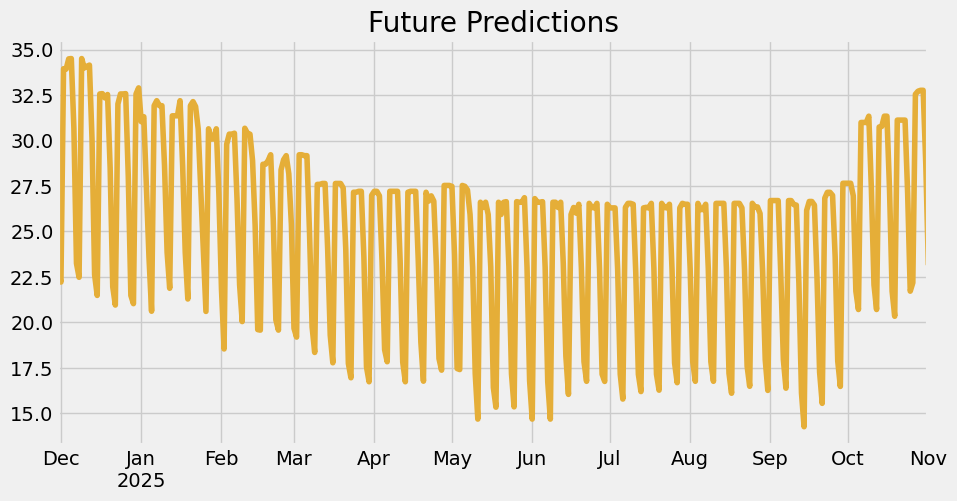

In [ ]:
future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[2],
                               title='Future Predictions')
plt.show()

In [ ]:
import pickle

with open("xgboost_model.pkl", "wb") as f:
    pickle.dump(model, f)

print("Model saved as xgboost_model.pkl")